In [153]:
#Libaries to Import
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import matplotlib
import seaborn as sns


In [154]:
#Data 
df = pd.read_csv("data/opex.csv", delimiter=";", decimal=",")
df.columns = ['year','opex']
df.head(3)
df.describe()

,opex
count,93.000000
mean,-1290.172043
std,355.623874
min,-2917.000000
25%,-1478.000000
50%,-1197.000000
75%,-1051.000000
max,-775.000000


In [155]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01
Time period end: 2022-09


In [156]:
df.columns

Index(['year', 'opex'], dtype='object')

In [157]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [158]:
#Setting index as the datetime column for easier manipulations: 
y = df.set_index('year')
y.index 

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
     

In [159]:
y.isnull().sum()

opex    0
dtype: int64

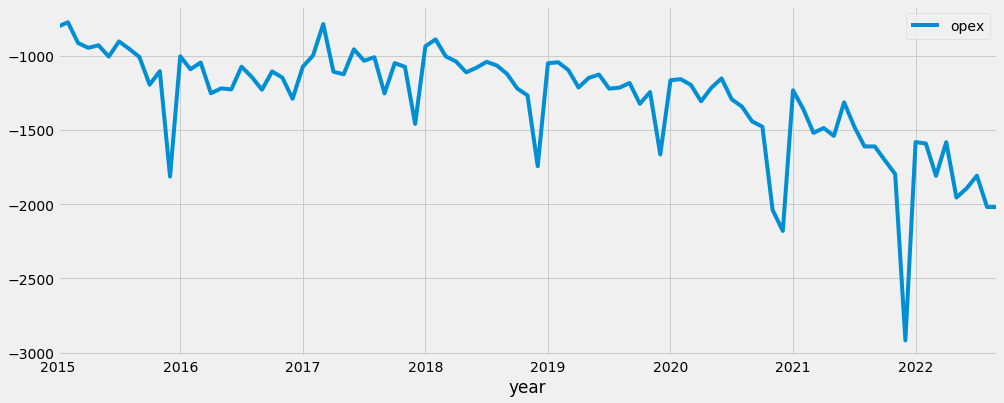

In [160]:
y.plot(figsize=(15, 6))
plt.show()

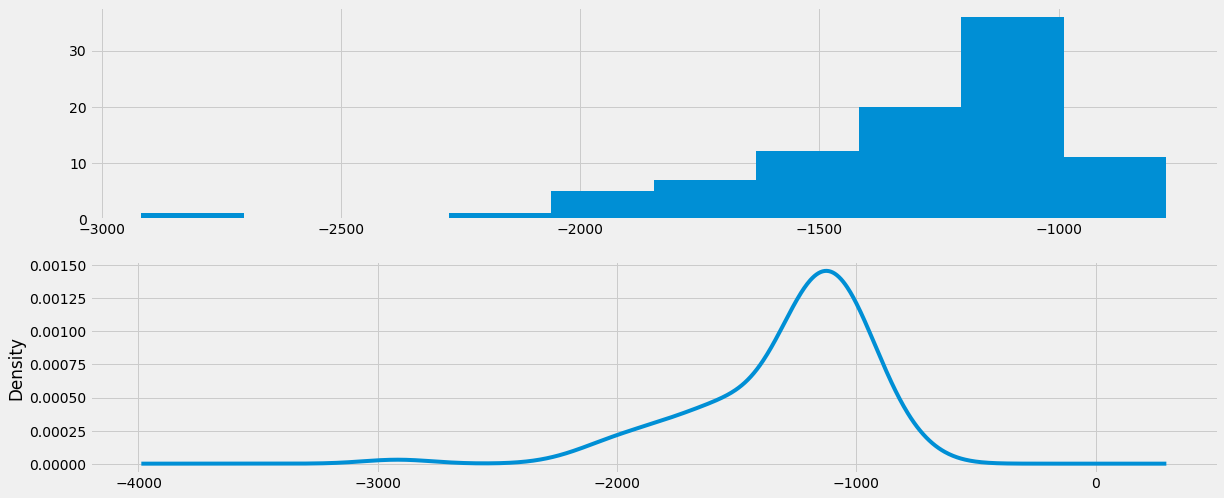

In [161]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data: 
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.opex.hist()
pyplot.subplot(212)
y.opex.plot(kind='kde')
pyplot.show()

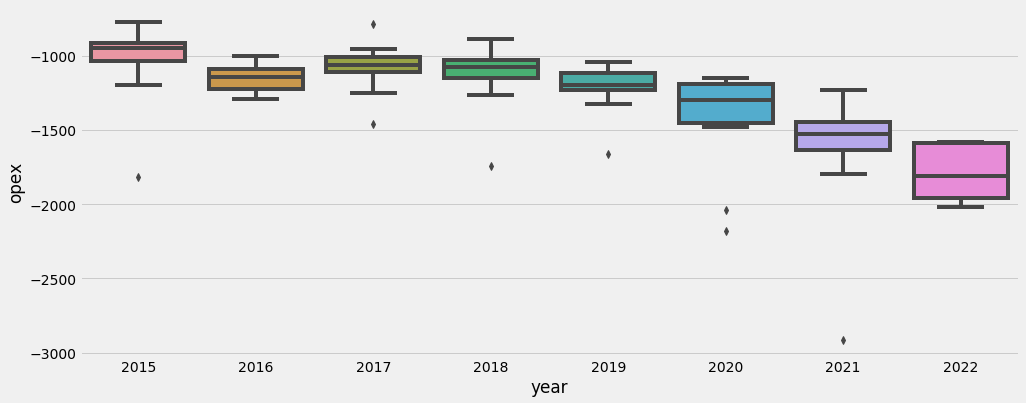

In [162]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.opex.index.year, y.opex, ax=ax)

In [163]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

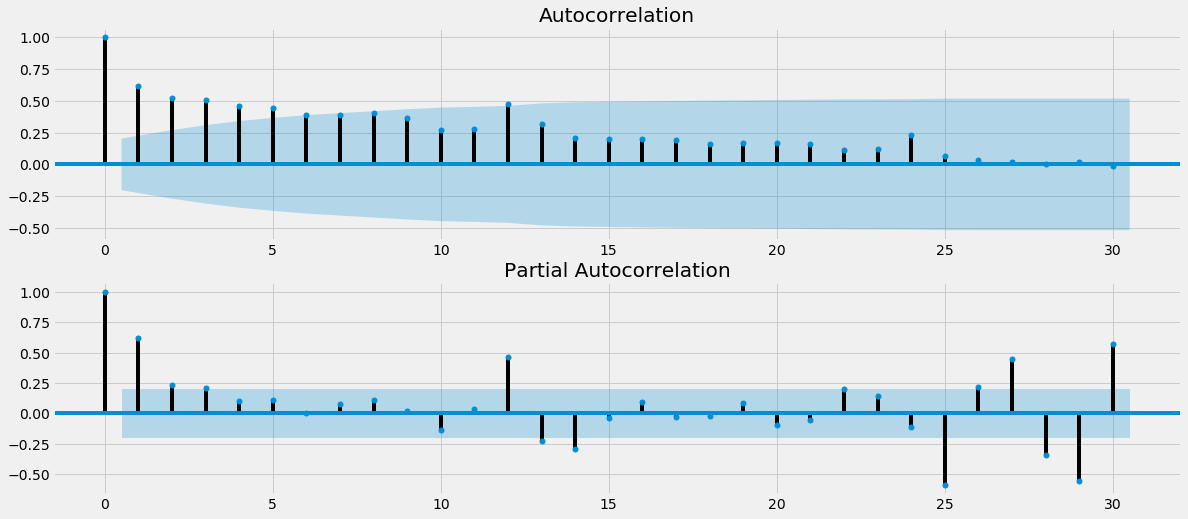

In [164]:
#Stationarity 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.opex, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.opex, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [165]:
#Augmented Dickey-Fuller Test & Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.opex, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                  3.470214
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [166]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [167]:
#ARIMA 
ts = y.opex - y.opex.shift()
ts.dropna(inplace=True)

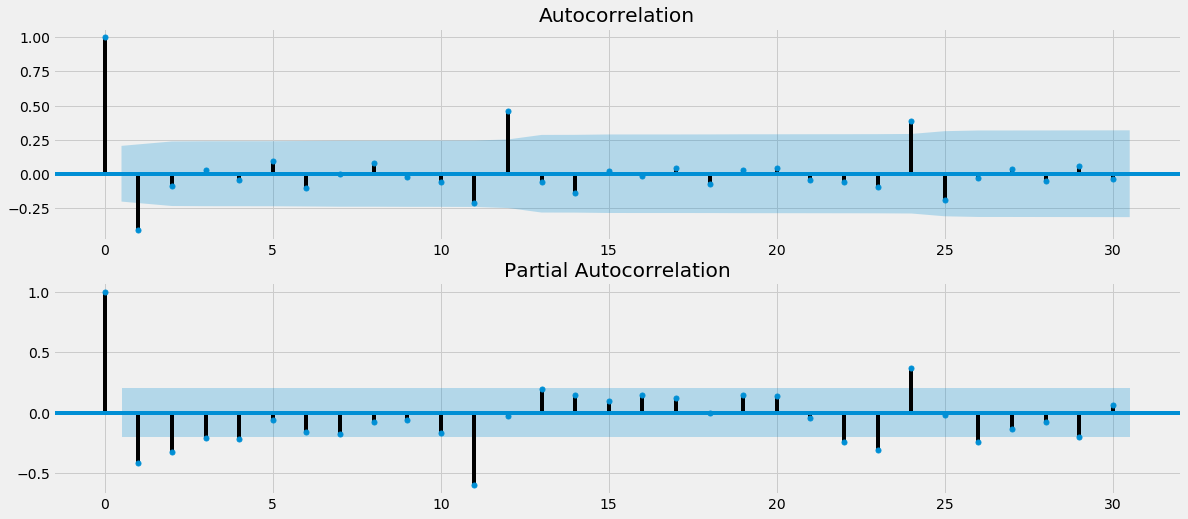

In [168]:
#ACF and PACF plots after differencing:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

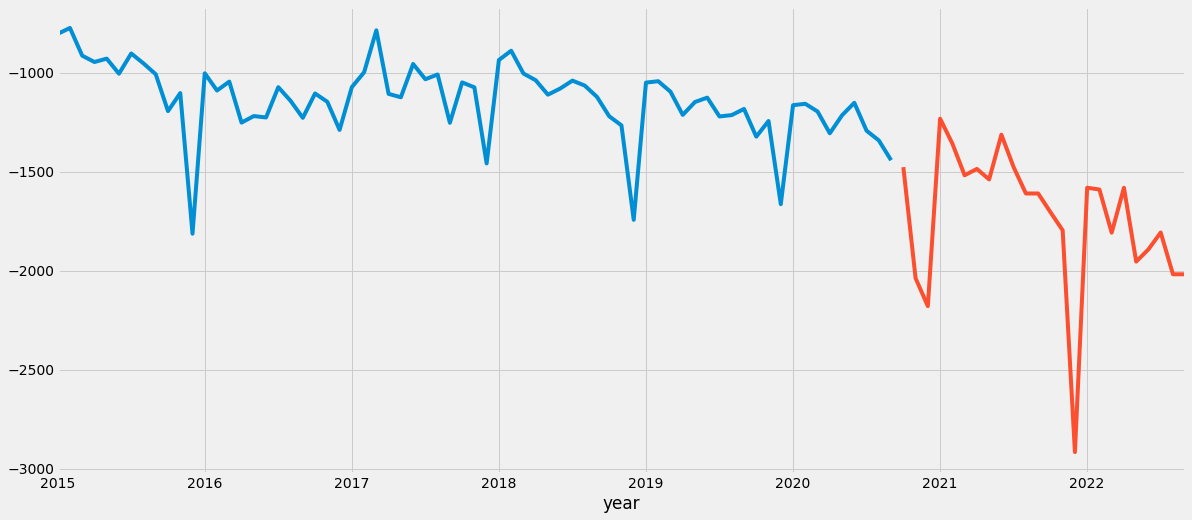

In [169]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['opex'].plot()
valid['opex'].plot()

In [170]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [171]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.opex   No. Observations:                   68
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -448.033
Method:                       css-mle   S.D. of innovations            170.893
Date:                Fri, 14 Oct 2022   AIC                            904.066
Time:                        09:21:11   BIC                            912.944
Sample:                    02-01-2015   HQIC                           907.583
                         - 09-01-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.1801      1.225     -3.413      0.001      -6.580      -1.780
ar.L1.D.opex     0.1619      0.122      1.322      0.186      -0.078       0.402
ma.L1.D.opex    -0.9999      0.053    -18.790      0.000      -1.104      -0.896
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.1776           +0.0000j            6.1776            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [172]:
#SARIMA Modeling
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [173]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1154.2851576906924
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1003.3284216199597
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:864.4348398092311
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:740.3806167105972
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:879.4201695356429
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:824.584607743604
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:737.948529693125
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:725.7192721631002
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1073.2588052938033
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:947.2952646376021
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:852.228915285002
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:725.31783546522
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:880.6052325984284
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:860.4773265353923
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:735.153792970802
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:708.6962754072848
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:918.4188325615175
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:843.1674596092143
ARIMA(0, 1, 0)x(0, 1, 0, 6)12 -

In [174]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              opex   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -341.406
Date:                           Fri, 14 Oct 2022   AIC                            690.812
Time:                                   09:21:28   BIC                            698.768
Sample:                               01-01-2015   HQIC                           693.880
                                    - 09-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6605      0.112     -5.894      0.000      -0.880      -0.441
ar.S.L6       -0.8598      0.066    -13.121      0.000      -0.988      -0.731
ma.S.L6        0.0411      0.171      0.241      0.810      -0.293       0.376
sigma2      1.812e+04   3748.680      4.835      0.000    1.08e+04    2.55e+04
===================================================================================
Ljung-Box (Q):                       26.09   Jarque-Bera (JB):                17.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [184]:
#Period for forecast
start_analysis = "2018-01"
end_analysis = "2020-12"

#Predictions
pred = min_aic_model.get_prediction(start=start_analysis,end=end_analysis, dynamic=False)

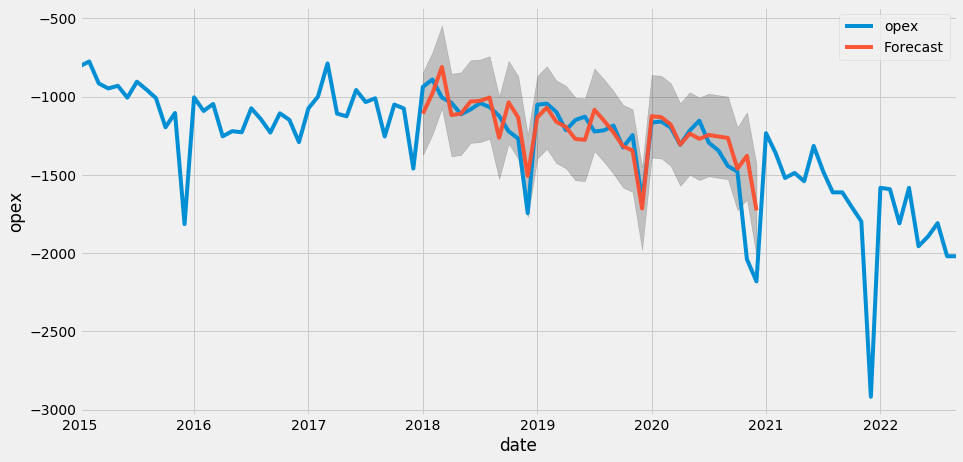

2018-01-01   -1107.996827
2018-02-01    -979.365764
2018-03-01    -809.456122
2018-04-01   -1117.090627
2018-05-01   -1108.085466
2018-06-01   -1030.800166
2018-07-01   -1026.268469
2018-08-01   -1005.014322
2018-09-01   -1262.091511
2018-10-01   -1035.715724
2018-11-01   -1132.632341
2018-12-01   -1506.041291
2019-01-01   -1131.639568
2019-02-01   -1069.455920
2019-03-01   -1160.318810
2019-04-01   -1193.169306
2019-05-01   -1269.950025
2019-06-01   -1275.213290
2019-07-01   -1083.598642
2019-08-01   -1152.246955
2019-09-01   -1228.083738
2019-10-01   -1316.351147
2019-11-01   -1343.859215
2019-12-01   -1714.545402
2020-01-01   -1124.874304
2020-02-01   -1130.321833
2020-03-01   -1177.434093
2020-04-01   -1305.810627
2020-05-01   -1234.985896
2020-06-01   -1269.138951
2020-07-01   -1244.298589
2020-08-01   -1254.222245
2020-09-01   -1263.229686
2020-10-01   -1459.581261
2020-11-01   -1378.087530
2020-12-01   -1726.134433
Freq: MS, dtype: float64
             lower opex   upper opex
20

In [185]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.95, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('opex')
plt.legend()
plt.show()

print(pred.predicted_mean)
print(pred_ci)

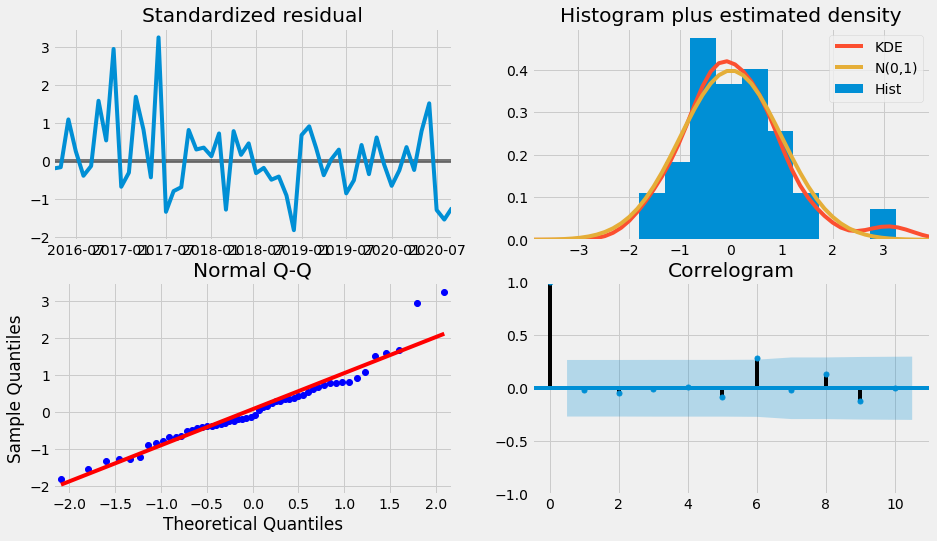

In [186]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

In [187]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [189]:
#Evaluate Forecast
y_forecasted = pred.predicted_mean.values
y_truth = y[start_analysis:end_analysis].opex.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27897.73


In [190]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 167.03


In [191]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,rmse
0,0.621616,108.23225,70.704719,27897.733894,167.026147
